# **fMNIST Classification with Dense Neural Networks (using Tensorflow)**

# **Problem Statement**
#### The objective of this report is to run a good EDA on fMNIST, train a neural network using Tensorflow, evaluate it using sklearn, and provide clear conclusions. 

## **Importing Libraries**

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

# plotting modules
from matplotlib import pyplot as plt
import matplotlib.patches as patches  # for curved arrows

# cross validation functions
from sklearn.model_selection import cross_validate, cross_val_predict

# performance metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score,  classification_report, accuracy_score

from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

## **Getting Data**

* Here we will use [Kaggle](https://www.kaggle.com/code/abhishekyana/fmnist-dataset-with-cnns-tensorflow/data) as our data repository. 
* Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples.Each example is a 28x28 grayscale image, associated with a label from 10 classes.
There are 10 different classes of images, as following:
0: T-shirt/top 
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneakers
8: Bag
9: Ankle boot

In [2]:
train_df = np.genfromtxt('data/fashion-mnist_train.csv', dtype='uint8', delimiter=',', skip_header=1)

In [3]:
test_df = np.genfromtxt('data/fashion-mnist_test.csv', dtype='uint8', delimiter=',' , skip_header=1)

In [4]:
# Divide the data into training and testing sets.
X_train = train_df[:, 1:]
y_train = train_df[:, 0]

X_test = test_df[:, 1:]
y_test = test_df[:, 0]

## **Exploring the Data**

In [5]:
# Displays the data types and shapes of the training and test sets.
print(f'Image DType: {type(X_train)}')
print(f'Image Element DType: {type(X_train[0,0])}')
print(f'Label Element DType: {type(y_train[0])}')
print('**Shapes:**')
print('Train Data:')
print(f'Images: {X_train.shape}')
print(f'Labels: {y_train.shape}')
print('Test Data:')  

print(f'Images: {X_test.shape}')
print(f'Labels: {y_test.shape}')
print('Image Data Range:')
print(f'Min: {X_train.min()}')
print(f'Max: {X_train.max()}')

Image DType: <class 'numpy.ndarray'>
Image Element DType: <class 'numpy.uint8'>
Label Element DType: <class 'numpy.uint8'>
**Shapes:**
Train Data:
Images: (60000, 784)
Labels: (60000,)
Test Data:
Images: (10000, 784)
Labels: (10000,)
Image Data Range:
Min: 0
Max: 255


In [6]:
# Reshape and normalize the image data.
X_train = X_train.reshape((60000, 28 * 28))  
X_test = X_test.reshape((10000, 28 * 28))

X_train = X_train.astype("float32") / 255  
X_test = X_test.astype("float32") / 255  

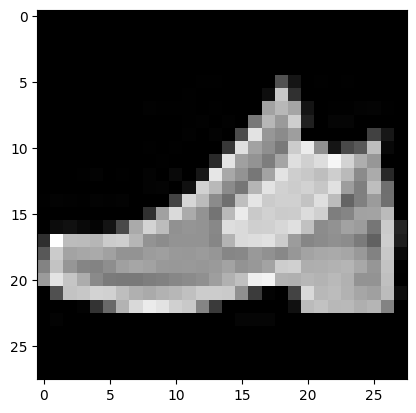

In [7]:
# Plot a sample image data
plt.imshow(X_train[1].reshape(28,28), cmap='gray')

In [8]:
# print the label associated with the image
print(f'Label: {y_train[1]}')

Label: 9


### **Visualize first 25 images to understand the structure and content of the dataset.**

Kaggle : [Reference](https://www.kaggle.com/code/kanikaw/mnist-nn-from-scratch?scriptVersionId=164122350&cellId=8)

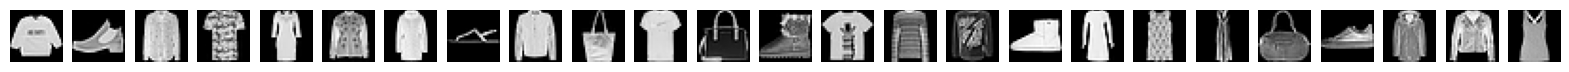

In [9]:
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(1, 25, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

Observations- 
- Each small image represents a different item of clothing or accessory from the Fashion MNIST dataset.
- The images are displayed in grayscale, with varying shades of gray to depict different features and textures.

### **Check class distribution**

Train set image class distribution    

Kaggle : [Reference](https://www.kaggle.com/code/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist?scriptVersionId=66719946&cellId=13)

In [10]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    label_counts = {}

    # Count the number of items in each class
    for label in data:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

    # Get total number of samples
    total_samples = len(data)


    # Calculate percentage and display results
    for label, count in label_counts.items():
        percent = (count / total_samples) * 100
        print(f"{labels[label]:<20s}:   {count} or {percent:.2f}%")

get_classes_distribution(y_train)

Pullover            :   6000 or 10.00%
Ankle Boot          :   6000 or 10.00%
Shirt               :   6000 or 10.00%
T-shirt/top         :   6000 or 10.00%
Dress               :   6000 or 10.00%
Coat                :   6000 or 10.00%
Sandal              :   6000 or 10.00%
Bag                 :   6000 or 10.00%
Sneaker             :   6000 or 10.00%
Trouser             :   6000 or 10.00%


Plot the class distribution.    

Kaggle : [Reference](https://www.kaggle.com/code/fold10/exploring-mnist?scriptVersionId=129644281&cellId=4)

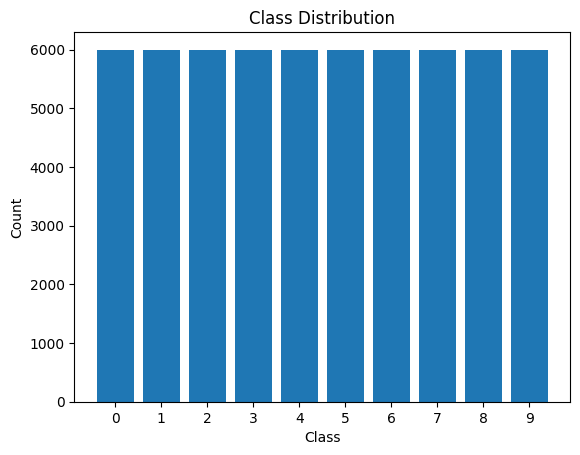

In [11]:
# Check for class imbalance in the mnist dataset
class_counts = np.bincount(y_train.astype(int))
plt.bar(np.arange(10), class_counts, tick_label=np.arange(10))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

Observations : 
- The distribution of classes is  balanced

### **Explore pixel intensity distributions for a sample image**

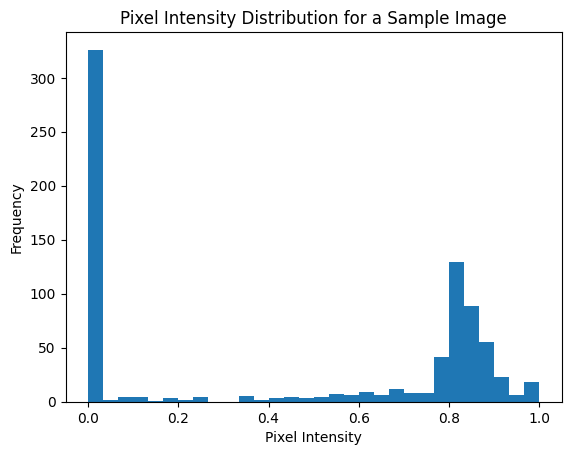

In [12]:
plt.hist(X_train[0], bins=30)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution for a Sample Image')
plt.show()

Observations : 
- The histogram is skewed toward the left side, indicating that a significant number of pixels have low intensity (darker shades).
- There is a smaller peak around 0.8 pixel intensity, suggesting the presence of lighter pixels.

# **Define the models**

In [13]:
# Baseline model with default hyperparameters
model1 = keras.Sequential([
    layers.Dense(128, activation="relu"), # neurons - 128. This layer processes the input data and applies the ReLU activation function to the weighted sum of inputs.
    layers.Dense(64, activation='relu'), # neurons - 64. Further processes the output from the first  layer.
    layers.Dense(10, activation="softmax") # neurons - 10 . Produces the final output probabilities for each class
])

In [14]:
# Increased number of neurons in the first hidden layer to help the model capture more complex patterns in the data.
model2 = keras.Sequential([
    layers.Dense(256, activation="relu"), # neurons - 256. This layer processes the input data and applies the ReLU activation function to the weighted sum of inputs.
    layers.Dense(64, activation='relu'), # neurons - 64. Further processes the output from the first  layer.
    layers.Dense(10, activation="softmax") # neurons - 10 . Produces the final output probabilities for each class
])

In [15]:
  # Model 3: Increased number of epochs
model3 = keras.Sequential([
    layers.Dense(128, activation="relu"), # neurons - 128. This layer processes the input data and applies the ReLU activation function to the weighted sum of inputs.
    layers.Dense(64, activation='relu'), # neurons - 64. Further processes the output from the first  layer.
    layers.Dense(10, activation="softmax") # neurons - 10 . Produces the final output probabilities for each class
])

## **Define the Loss Function, Optimizer and Metrics**

In [16]:
# Configure the neural network model for training 
model1.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model2.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model3.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# **Data Split to Train, Test and Validation** 

In [17]:
# 20% of the training data will be used for validation in this case
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= .2, random_state=42) 

In [18]:
print(f'Train_Images: {X_train.shape}')
print(f'Train_Labels: {y_train.shape}')
print(f'Val_Images: {X_val.shape}')
print(f'Val_Labels: {y_val.shape}')

Train_Images: (48000, 784)
Train_Labels: (48000,)
Val_Images: (12000, 784)
Val_Labels: (12000,)


Setting up a ModelCheckpoint callback for each model to save the model weights whenever the validation loss improves

In [19]:

model1_checkpoint_callback = ModelCheckpoint(
    filepath='best_model1.hdf5',
    save_weights_only=False,  # Optionally save only weights instead of the full model
    monitor='val_loss',
    mode='min',  # Monitor validation loss and save on minimum
    save_best_only=True)

model2_checkpoint_callback = ModelCheckpoint(
    filepath='best_model2.hdf5',
    save_weights_only=False,  # Optionally save only weights instead of the full model
    monitor='val_loss',
    mode='min',  # Monitor validation loss and save on minimum
    save_best_only=True)

model3_checkpoint_callback = ModelCheckpoint(
    filepath='best_model3.hdf5',
    save_weights_only=False,  # Optionally save only weights instead of the full model
    monitor='val_loss',
    mode='min',  # Monitor validation loss and save on minimum
    save_best_only=True)

## **Training ("Fitting") the model**

Fitting each model on the training data, validating on the validation set, and saving the training history for later analysis.

In [25]:
history1 = model1.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val,y_val), callbacks= model1_checkpoint_callback)
history2 = model2.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_val,y_val), callbacks= model2_checkpoint_callback)
history3 = model3.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val,y_val), callbacks= model3_checkpoint_callback)

Epoch 1/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.2946 - accuracy: 0.8967 - val_loss: 0.4566 - val_accuracy: 0.8704
Epoch 2/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2902 - accuracy: 0.8986 - val_loss: 0.4284 - val_accuracy: 0.8798
Epoch 3/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2856 - accuracy: 0.8989 - val_loss: 0.4146 - val_accuracy: 0.8781
Epoch 4/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2816 - accuracy: 0.9026 - val_loss: 0.4577 - val_accuracy: 0.8798
Epoch 5/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2767 - accuracy: 0.9035 - val_loss: 0.4574 - val_accuracy: 0.8755
Epoch 6/10
1500/1500 [==============================] - 11s 8ms/step - loss: 0.2733 - accuracy: 0.9052 - val_loss: 0.4674 - val_accuracy: 0.8708
Epoch 7/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2705 - accuracy: 0.9083 - val_loss: 0.4980 - val_accu

Text(0.5, 1.0, 'Training and validation accuracy')

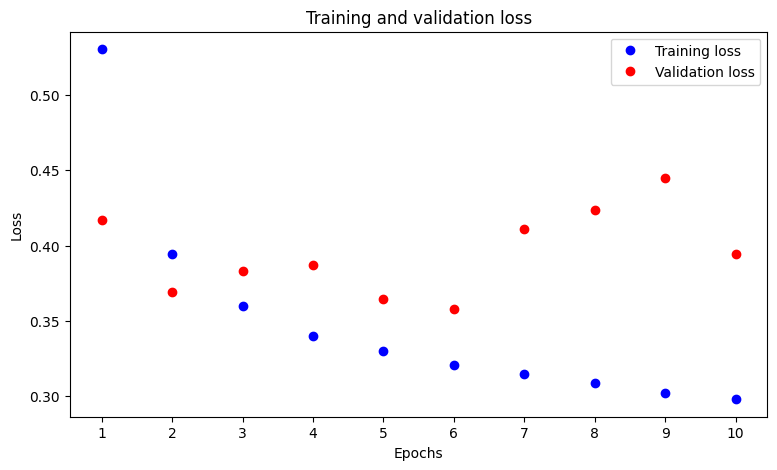

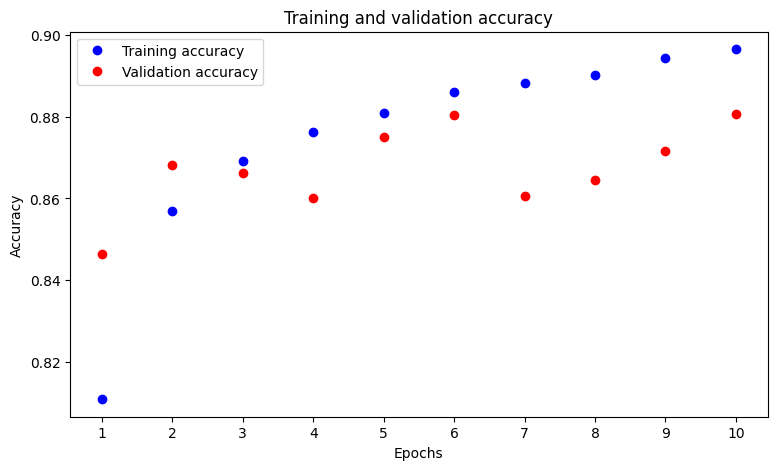

In [21]:
# plot the training and validation loss for Model 1
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
loss_values = history1.history["loss"]
val_loss_values = history1.history["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "ro", label="Validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.title("Training and validation loss")

# plot the training and validation accuracy for Model 1
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
loss_values = history1.history["accuracy"]
val_loss_values = history1.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training accuracy")
plt.plot(epochs, val_loss_values, "ro", label="Validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and validation accuracy")

The best set of weights to avoid overfitting for the first model would be epoch 4. This is where the validation loss is at its lowest. After this point, the validation loss starts to increase while training loss continues to decrease, indicating overfitting.

Text(0.5, 1.0, 'Training and validation accuracy')

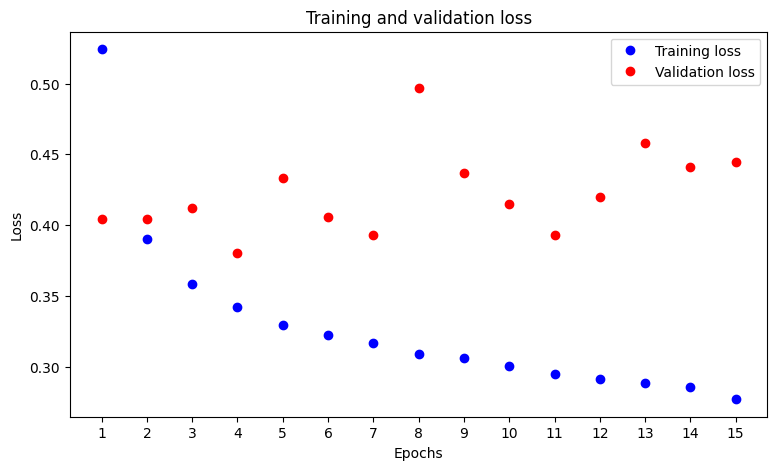

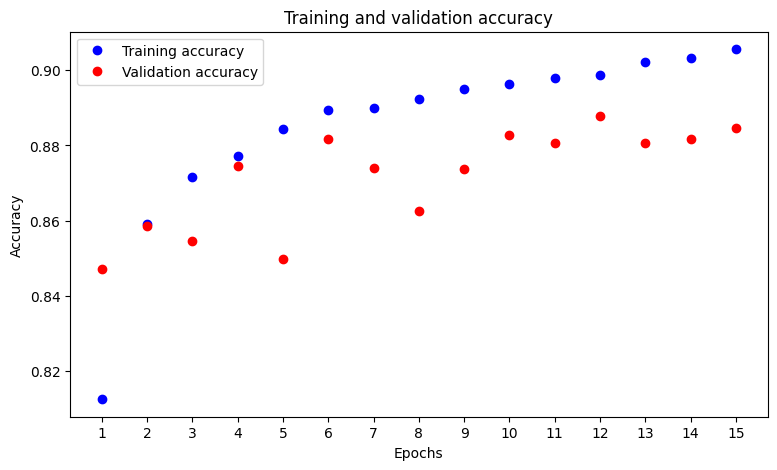

In [22]:
# plot the training and validation loss for Model 2
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
loss_values = history2.history["loss"]
val_loss_values = history2.history["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "ro", label="Validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.title("Training and validation loss")

# plot the training and validation accuracy for Model 2
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
loss_values = history2.history["accuracy"]
val_loss_values = history2.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training accuracy")
plt.plot(epochs, val_loss_values, "ro", label="Validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and validation accuracy")

The best set of weights to avoid overfitting for the second model would be epoch 5. This is where the validation loss is at its lowest. After this point, the validation loss starts to increase while training loss continues to decrease, indicating overfitting.

Text(0.5, 1.0, 'Training and validation accuracy')

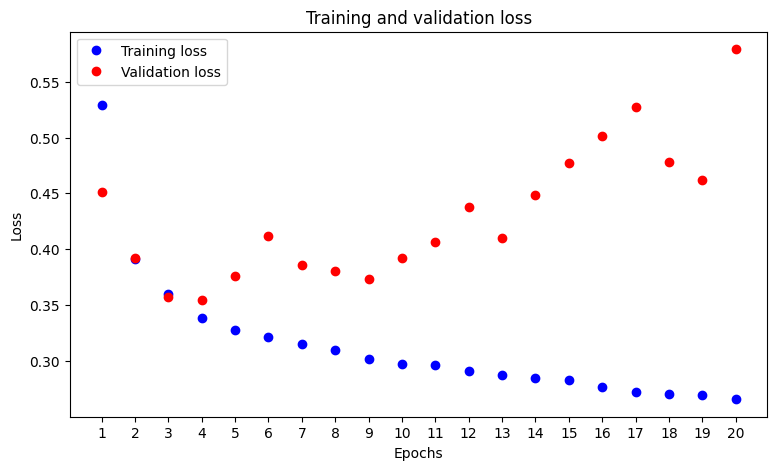

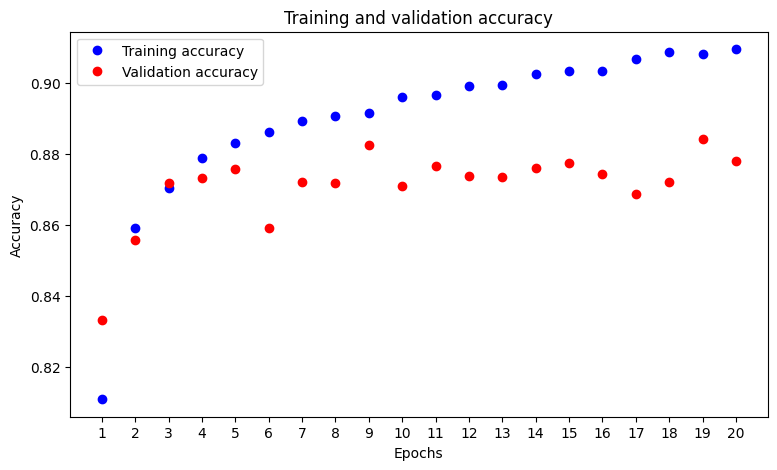

In [23]:
# plot the training and validation loss for Model 3
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
loss_values = history3.history["loss"]
val_loss_values = history3.history["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "ro", label="Validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.title("Training and validation loss")

# plot the training and validation accuracy for Model 3
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
loss_values = history3.history["accuracy"]
val_loss_values = history3.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training accuracy")
plt.plot(epochs, val_loss_values, "ro", label="Validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and validation accuracy")

The best set of weights to avoid overfitting for the third model would be epoch 5. This is where the validation loss is at its lowest. After this point, the validation loss starts to increase while training loss continues to decrease, indicating overfitting.

In [24]:
best_model1 = load_model('best_model1.hdf5') 
best_model2 = load_model('best_model2.hdf5')
best_model3 = load_model('best_model3.hdf5')

OSError: No file or directory found at best_model2.hdf5

## **Model Evaluation on Validation Set**

In [ ]:
val_loss_model1, val_acc_model1 = best_model1.evaluate(X_val, y_val)
print(f"val_acc_model1: {val_acc_model1}")

val_loss_model2, val_acc_model2 = best_model2.evaluate(X_val, y_val)
print(f"val_acc_model2: {val_acc_model2}")

val_loss_model2, val_acc_model3 = best_model2.evaluate(X_val, y_val)
print(f"val_acc_model3: {val_acc_model3}")

In [ ]:
# Predict classes using validation set
y_pred_model1 = best_model1.predict(X_val)
y_pred_classes_model1 = np.argmax(y_pred_model1, axis=1)

y_pred_model2 = best_model2.predict(X_val)
y_pred_classes_model2 = np.argmax(y_pred_model2, axis=1)

y_pred_model3 = best_model3.predict(X_val)
y_pred_classes_model3 = np.argmax(y_pred_model3, axis=1)

In [ ]:
def print_validation_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy of Validation Data: "+ str(accuracy))
    
    return accuracy

In [ ]:
metrics  = print_validation_report(y_val, y_pred_classes_model1)

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred_classes_model1)
precision = precision_score(y_val, y_pred_classes_model1, average='macro')
recall = recall_score(y_val, y_pred_classes_model1, average='macro')
f1 = f1_score(y_val, y_pred_classes_model1, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Observations on Validation Set :
- The model achieved an accuracy of approximately 87.35% on the validation set.
- Model has achieved high precision and recall, which suggests that it can make accurate positive predictions while minimizing false negatives.
- F1 score of approximately 87.61% reflects a good balance between precision and recall.

## **Model Evaluation on Test Set**

In [ ]:
model = load_model('model1.hdf5') 

# Predict classes using test set
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Evaluate model performance on test set
test_accuracy = accuracy_score(y_test, y_test_pred_classes)
print("Test Accuracy:", test_accuracy)

In [ ]:
metrics  = print_validation_report(y_test, y_test_pred_classes)

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred_classes)
precision = precision_score(y_test, y_test_pred_classes, average='macro')
recall = recall_score(y_test, y_test_pred_classes, average='macro')
f1 = f1_score(y_test, y_test_pred_classes, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Observations on Validation Set :
- The model achieved an accuracy of approximately 88.26% on the test set which is slightly higher than the accuracy achieved for validation set.
- Considering the Precision, Recall and F1 score, the model’s performance on the test set is consistent with its performance on the validation set.

In [ ]:
# Plot precision-recall curve based on the model’s predictions and the true labels for class 5
y_test_binary = (y_test == 5).astype(int)
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_test_pred[:, int(5)])

# Plot precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

Observations :
 - At the beginning of the curve (low recall values), the precision is very high (close to 1.0).
 - The curve shows a sharp drop in precision after approximately 0.8 recall.

## **Increase precision for class 5**

In [ ]:
threshold = 0.8  # Adjust threshold to increase precision

# Convert probabilities to predicted class labels based on the new threshold
y_val_pred_class = ( y_test_pred[:, 5] > threshold).astype(int)

# Calculate precision after adjusting the threshold
precision_after_adjustment = precision_score(y_test_binary, y_val_pred_class)
print("Precision after adjustment:", precision_after_adjustment)

## **Increase recall for class 5**

In [ ]:
# Convert probabilities to predicted class labels based on the new threshold
y_val_pred_class = (y_test_pred[:, 5] > threshold).astype(int)

# Calculate recall after adjusting the threshold
recall_after_adjustment = recall_score(y_test_binary, y_val_pred_class)
print("Recall after adjustment:", recall_after_adjustment)

Observations : Increase threshold to 0.8 
- Before adjusting the threshold, the model had a precision of 0.97 and a recall of 0.95 for class 5.
- After changing the threshold to 0.8, the precision slighty increases to 0.98 while the recall drops slightly to 0.938.
- The higher threshold (0.8) led to increased precision but at the cost of reduced recall.